In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(6432, 24)
(6432, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RL swings
idxs = np.where(X_motion[:, -1] == 1)[0]
X_motion_RL_swinging = X_motion[idxs]
Y_motion_RL_swinging = Y_motion[idxs]

## Predict RL foot -> x

In [8]:
X_motion_RL_swinging[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.24436159,  0.1244141 , -0.3833572 ,  0.23500231,
       -0.1260671 , -0.3818295 , -0.25937766,  0.12619635, -0.3904613 ,
       -0.25473124, -0.12715134, -0.38145515,  0.01411862, -0.00900215,
       -0.01705721,  0.05393084,  0.        ,  1.        ])

In [9]:
X_motion_RL_swinging[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.24436159,  0.1244141 , -0.3833572 ,  0.23500231,
       -0.1260671 , -0.3818295 , -0.25937766,  0.12619635, -0.3904613 ,
       -0.25473124, -0.12715134, -0.38145515,  0.01411862, -0.00900215,
       -0.01705721,  0.05393084,  0.        ,  1.        ])

### Linear Regression

In [17]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, 3:6], # Current motion command
               #X_motion_RL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RL_swinging[:, 6:8], # FL (x,y) position
               X_motion_RL_swinging[:, 9:11], # FR (x,y) position
               X_motion_RL_swinging[:, 12:14], # RL (x,y) position
               X_motion_RL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_x = LinearRegression()

# Fit the model
model_rl_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9738162869028143
RMSE:  0.020167230154912202
The lowest error is:  1.4890483163831902e-05
The highest error is:  0.09751636658480622
The avg. error is:  0.014168439942167068


In [18]:
model_rl_relative_swinging_x.coef_

array([[-7.85527555e-03, -3.33066907e-16, -3.33066907e-16,
         2.03973132e-01, -6.66133815e-16,  0.00000000e+00,
         2.49848376e+00, -1.73719248e+00,  7.22527478e-01,
         2.62697386e-01, -3.25092439e+00,  6.61325186e-01,
        -2.11894219e+00, -7.51022697e-01]])

In [19]:
model_rl_relative_swinging_x.intercept_

array([-2.08812562])

Text(0, 0.5, 'Predictions')

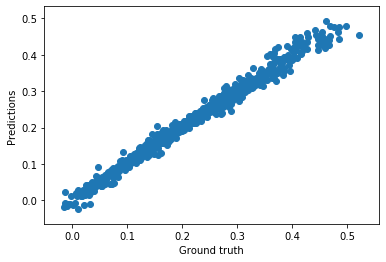

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict RL foot -> y

In [20]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, 3:6], # Current motion command
               #X_motion_RL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RL_swinging[:, 6:8], # FL (x,y) position
               X_motion_RL_swinging[:, 9:11], # FR (x,y) position
               X_motion_RL_swinging[:, 12:14], # RL (x,y) position
               X_motion_RL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_y = LinearRegression()

# Fit the model
model_rl_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.1070541030147012
RMSE:  0.006932128138735537
The lowest error is:  5.02419090298023e-06
The highest error is:  0.038252601033882894
The avg. error is:  0.0051393180973623356


In [21]:
model_rl_relative_swinging_y.coef_

array([[-8.13426797e-03,  2.01227923e-16,  1.52655666e-16,
        -1.84107449e-03,  2.22044605e-16,  0.00000000e+00,
        -4.68975428e-01,  5.52041982e-01, -3.38497680e-01,
        -2.29424254e-01,  4.52721769e-01, -1.08173895e+00,
         6.15159518e-01,  8.35581693e-01]])

In [22]:
model_rl_relative_swinging_y.intercept_

array([0.61588349])

Text(0, 0.5, 'Predictions')

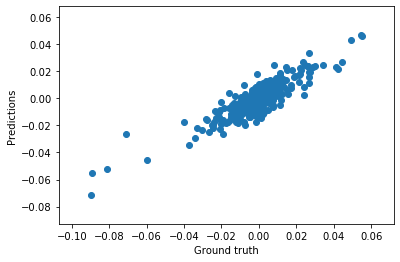

In [18]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')